# Convolutional Neural Nets

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/fitter-happier-models/blob/master/docs/notebooks/tf/04-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/fitter-happier-models?style=social)](https://github.com/particle1331/fitter-happier-models)

---

## Introduction

In this notebook, we consider **convolutional layers** which are used for extracting local features from digital images. A feature that is meaningful at a certain location should be equally meaningful at other places in the image. Moreover, discriminative features typically exist locally. These local features are captured by convolutional layers which can be stacked to obtain heirarchical features in the images in the hidden layers. This also naturally results in capacity reduction by allowing weight sharing between neurons.

**References:** {cite}`mlbook2022` {cite}`cams` {cite}`keras2` {cite}`dropout` [[Keras guides](https://keras.io/guides/transfer_learning/)]

In [1]:
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_inline import backend_inline

import tensorflow as tf
import tensorflow.keras as kr


DATASET_DIR = Path("../input/").absolute()

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')
matplotlib.rcParams["image.interpolation"] = "nearest"

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.6.4
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-05 02:10:20.647203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:10:20.804720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:10:20.805605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Convolution operation

Suppose we want to classify cat images using a linear model. Flattening the image into a vector is unstatisfying since we are discarding important spatial information (i.e. a network with a preprocessing layer that permutes the input achieves the same result). Notice that the two pixels indicated on the left image below probably do not need to be mixed to figure out that the image is a cat. On the other hand, three nearby pixels on the right image can form a linear combination that can be useful for determining cat-like features. This results in a very sparse **banded** weight matrix.

```{figure} ../../img/cat-conv.png
---
width: 40em
---
Nearby pixels constitute meaningful features of images.
```

Let $\boldsymbol{\mathsf X}$ be the input image and $\boldsymbol{\mathsf{S}}$ be the output feature map. Suppose ${\mathsf n}^2 = |\boldsymbol{\mathsf X}|$ and ${\mathsf m}^2 = |\boldsymbol{\mathsf{S}}|.$ Having a banded weight matrix reduces the size of the weight matrix from $\mathcal{O}(\mathsf{n}^2{\mathsf m}^2)$ to $\mathcal{O}({\mathsf k}^2{\mathsf m}^2)$ where a local region of $\mathsf k \times \mathsf k$ pixels in the input are mixed. It makes sense to further constrain the weights in the local region to be equal througout the image since we want to capture translationally invariant features. This further reduces the number of weights to $\mathcal{O}({\mathsf k}^2).$ The resulting linear operation is called a **convolution** written in two spatial dimensions as:

$$
\boldsymbol{\mathsf{S}} = (\boldsymbol{\mathsf X} \circledast \boldsymbol{\mathsf{K}})_{ij} = \sum_{x = 0}^{{\mathsf k}-1} \sum_{y=0}^{{\mathsf k}-1} {\boldsymbol{\mathsf X}}_{i + x, j + y} \, {\boldsymbol{\mathsf{K}}}_{xy}.
$$

Observe that spatial ordering of the pixels in the input $\boldsymbol{\mathsf X}$ is somehow preserved in the output $\boldsymbol{\mathsf{S}}.$ This is nice since we want to preserve spatial information across a stack of convolution operations.

```{margin}
Figure source:<br>
[`deepimaging.github.io`](https://deepimaging.github.io/lectures/lecture_9_intro_to_CNN's.pdf)
```
```{figure} ../../img/conv-cat-99.png
---
width: 30em
---
Banded Toeplitz matrix for classifying cat images. The horizontal vectors contain the same pixel values.
```

### Convolution layers

Convolution layers extend convolutions defined above to handle images with multiple **channels**. Similarly, we want to output feature maps with channels as this adds a further semantic dimension. The layer learns two-dimensional kernels $\boldsymbol{\mathsf{K}}$ for each input channel. The results of convolutions in each input channel are added to contribute to the preactivation pixel in the output channel. This entire process is repeated to get multiple output channels. The formula for convolution can be written as:

$$
\begin{aligned}
{\bar{\boldsymbol{\mathsf X}}}_{ij,\, k} 
&= \varphi\left({\boldsymbol{\mathsf u}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1} ({\boldsymbol{\mathsf X}}_{[:,\, :,\, c]} \circledast {\boldsymbol{\mathsf K}}_{[:,\,:,\, c,\,{k}]})_{ij} \right) \\
&= \varphi\left({\boldsymbol{\mathsf u}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1}\sum_{x = 0}^{{\mathsf k}-1} \sum_{y=0}^{{\mathsf k}-1} {\boldsymbol{\mathsf X}}_{i + x,\, j + y,\, c} \, {\boldsymbol{\mathsf K}}_{xyc,{k}} \right) \\
\end{aligned}
$$

for $k = 0, \ldots, {\mathsf c}_\text{out}-1$. The input and output tensors, $\boldsymbol{\mathsf{X}}$ and $\bar{\boldsymbol{\mathsf{X}}}$, have the same dimensionality and semantic structure which makes sense since we want to stack convolutional layers as modules, and the kernel $\boldsymbol{\mathsf{K}}$ has shape $({\mathsf k}, {\mathsf k}, {\mathsf c}_\text{in}, {\mathsf c}_\text{out}).$ The resulting feature maps inherit the spatial ordering in its inputs along its spatial dimensions. Also note that convolution requires the same set of operations as a linear layer it just applies weights to different parts of the image.

2022-12-05 02:10:21.230989: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 02:10:21.231703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:10:21.232642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:10:21.233343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

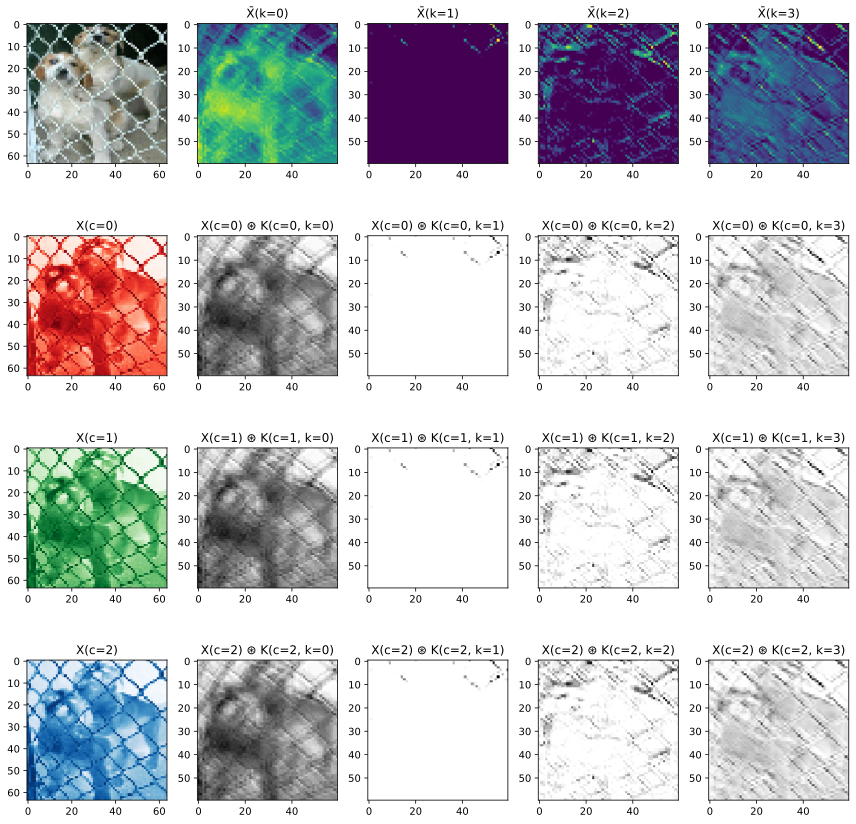

In [2]:
def conv_components(*, X, conv, act):
    """Components of a convolution of an RGB image with 4 output channels."""
    
    cmaps = ['Reds', 'Greens', 'Blues']

    # Get kernel weights
    conv.build(input_shape=X.shape)
    K, u = conv.get_weights()

    c_in  = X.shape[-1]
    c_out = K.shape[-1]

    # Iterate over in channels
    fig, ax = plt.subplots(c_in+1, c_out+1, figsize=(12, 12))
    ax[0, 0].imshow(X[0])
    for c in range(c_in):
        ax[c+1, 0].set_title(f'X(c={c})')
        ax[c+1, 0].imshow(X[0, :, :, c], cmap=cmaps[c])

    # Iterate over kernel filters
    outs = {}
    for k in range(c_out):
        conv_k = kr.layers.Conv2D(filters=1, kernel_size=conv.kernel_size, activation=act)
        conv_k.build(input_shape=(X.shape[1:]))
        T, v = conv_k.get_weights()
        T[:, :, :, 0] = K[:, :, :, k]
        v[0] = u[k]
        conv_k.set_weights([T, v])
        for c in range(c_in):
            outs[(c, k)] = conv_k(tf.cast(X, tf.float32) / 255.)[0, :, :, 0]
            ax[c+1, k+1].imshow(outs[(c, k)], cmap='Greys') 
            ax[c+1, k+1].set_title(f"X(c={c}) ⊛ K(c={c}, k={k})")

    # Sum convolutions for each input channel
    for k in range(c_out):
        ax[0, k+1].imshow(sum([outs[(c, k)] for c in range(c_in)]))
        ax[0, k+1].set_title(r"$\bar{\mathrm{X}}$" + f'(k={k})')

    fig.tight_layout()
    return outs


dog = DATASET_DIR / "cat-and-dog/test_set/test_set/dogs/dog.4008.jpg"
image_raw = tf.io.read_file(str(dog))
X = tf.image.decode_image(image_raw)[None, :, :, :]
X = tf.cast(tf.image.resize(X, size=(64, 64)), tf.float32) / 255.

tf_conv = kr.layers.Conv2D(filters=4, kernel_size=5, activation="relu")
conv_components(X=X, conv=tf_conv, act='relu');

**Figure.** Here we can see that the channels of convolutional layers are analogous to units of dense layers. Each kernel in entries `i,j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms form the output map `X̅(k=j)` above. This looks like matrix multiplication which dense layers implement but with convolutions between matrices instead of products between numbers. 

<br>

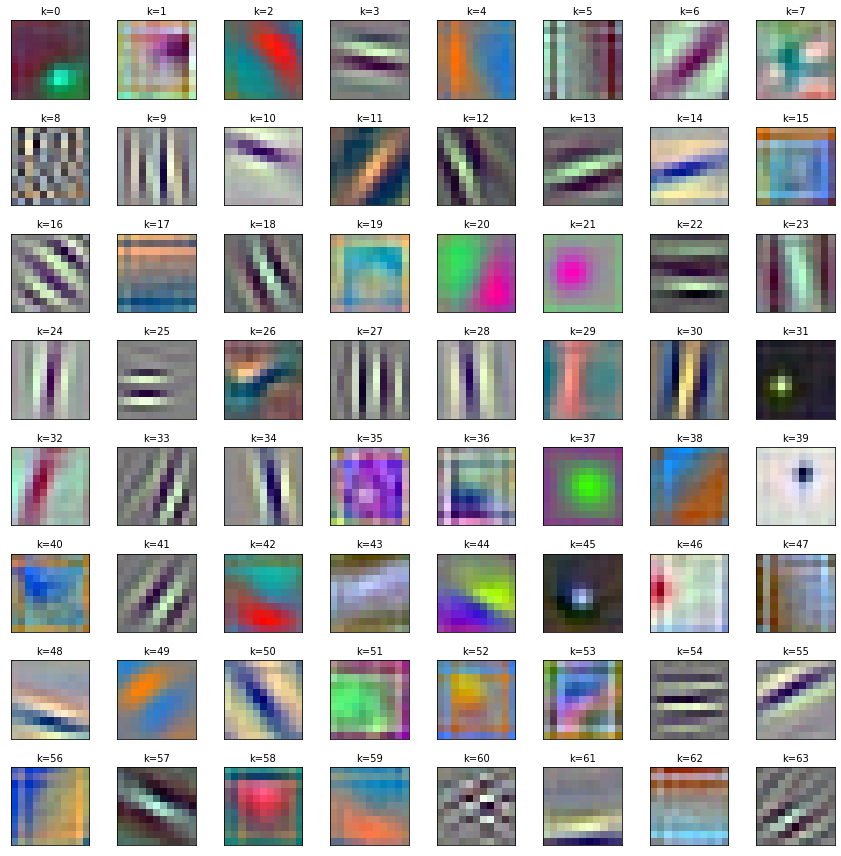

In [3]:
from torchvision.models import alexnet

def plot_alexnet_weights():
    model = alexnet(pretrained=True, progress=True)
    layers = list(model.parameters())[0]

    fig, ax = plt.subplots(8, 8, figsize=(12, 12))
    for i in range(64):
        K = layers[i]
        K = (K - K.min()) / (K.max() - K.min())
        ax[divmod(i, 8)].set_title(f"k={i}", fontsize=10)
        ax[divmod(i, 8)].imshow(K.detach().numpy().transpose(1, 2, 0));
        ax[divmod(i, 8)].set_xticks([])
        ax[divmod(i, 8)].set_yticks([])

    fig.tight_layout()
    

plot_alexnet_weights()

**Figure.** AlexNet {cite}`imagenet-paper` learns edge and blob detectors in the first layer. The network learning these means that edges and blobs of colors are features that occur  locally (i.e. in an 11×11 window) throughout the images.

<br>

**Formula.** Here we implement the formula above for convolution and check whether it is consistent with Keras `Conv2D`. This layer expects input images to have shape `(B, H, W, c)` for a batch input of size `B` of `H × W` images with `c` channels.

Input shape:  (1, 64, 64, 3)
Output shape: (1, 60, 60, 4)
Kernel shape: (5, 5, 3, 4)
Bias shape:   (4,)
Mean absolute error = 5.2645134e-08

Output components (from scratch):


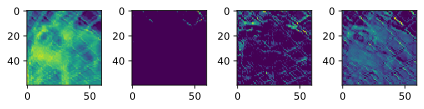

In [4]:
@np.vectorize
def np_relu(x):
    return max(0.0, x)

def scratch_conv(X, K, u, activation=None):
    """Implementing a 2D convolutional layer from scratch."""

    f = activation if activation is not None else lambda x: x

    h, w = K.shape[:2]
    B, H0, W0, c_in = X.shape
    H1 = H0 - h + 1
    W1 = W0 - w + 1
    c_out = K.shape[3]

    S = np.zeros(shape=(B, H1, W1, c_out))
    for b in range(S.shape[0]):
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                for k in range(S.shape[3]):
                    # Perform 3D convolution (h, w, c_in) for each out channel
                    S[b, i, j, k] = f(u[k] + (K[:, :, :, k] * X[b, i:i+h, j:j+w, :]).sum())
    return S


X = X.numpy()
K = tf_conv.weights[0].numpy()
u = tf_conv.weights[1].numpy()
S = scratch_conv(X, K, u, activation=lambda x: np_relu(x))

print("Input shape: ", X.shape)   # (B, H_in,  W_in,  c_in)
print("Output shape:", S.shape)   # (B, H_out, W_out, c_out)
print("Kernel shape:", K.shape)   # (h, w, c_in, c_out)
print("Bias shape:  ", u.shape)   # (c_out,)

# Check if above formula agrees with TF implementation
print("Mean absolute error =", np.abs(S - tf_conv(X)).mean())

# Plotting the images obtained using the above formula
print("\nOutput components (from scratch):")
fig, ax = plt.subplots(1, 4)
for j in range(4):
    ax[j].imshow(S[0, :, :, j])
fig.tight_layout()

Constructing the corresponding **Toeplitz matrix** of the operation:


Output components (from Toeplitz reconstruction):


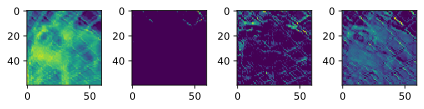

In [5]:
def output_shape(kernel, input_shape):
    h, w = kernel.shape[:2]
    B, H0, W0, c_in = input_shape
    H1, W1 = H0 - h + 1, W0 - w + 1
    c_out = kernel.shape[3]
    return B, H1, W1, c_out

def toeplitz(kernel, input_shape):
    """Constructing the Toeplitz matrix."""

    c_in = input_shape[3]
    c_out = kernel.shape[3]
    h, w  = kernel.shape[:2]
    H0, W0 = input_shape[1:3]
    B, H1, W1, c_out = output_shape(kernel, input_shape)
    
    T = np.zeros((H0 * W0, H1 * W1, c_in, c_out))
    for c in range(c_out):
        for k in range(c_in):
            for i in range(H1):
                for j in range(W1):
                    ii = i * W0 + j
                    jj = i * W1 + j
                    for hh in range(h):
                        T[ii + (hh * W0): ii + (hh * W0) + w, jj, k, c] = K[hh, :, k, c].reshape(-1)
    return T


# Constructing the output image
K = tf_conv.weights[0].numpy()
c_in = X.shape[3]
B, H1, H2, c_out = output_shape(K, X.shape)

T = toeplitz(K, X.shape)

print("\nOutput components (from Toeplitz reconstruction):")
fig, ax = plt.subplots(1, 4)
for k in range(c_out):
    s = []
    for c in range(c_in):
        x = X[0, :, :, c].reshape(-1)
        s.append(x @ T[:, :, c, k])
    s = sum(s)
    ax[k].imshow(np_relu(s).reshape(60, 60))

fig.tight_layout()

Toeplitz matrices for the first input channel:

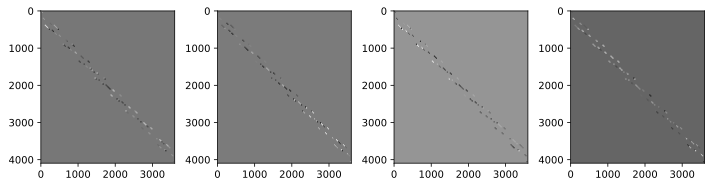

In [6]:
fig, ax = plt.subplots(1, c_out, figsize=(10, 6))
c = 0
for k in range(c_out):
    ax[k].imshow(T[:, :, c, k], cmap='gray');
plt.tight_layout()

Convolutions require much less weights than dense layers:

In [7]:
s = []
for t in range(4):
    t = T[:, :, 0, 0]
    s.append((t != 0).sum() / t.size)

print(f"Average sparsity: {sum(s)/4*100:.2f}%")

Average sparsity: 0.61%


### Padding and stride

The above definition of convolution can be modified to include a parameter called the **stride** that controls the step size of the kernel when it slides over the input image. A convolution layer with stride $\mathsf{s}$ computes for $k = 0, \ldots, {\mathsf c}_\text{out}-1$:

$$
\begin{aligned}
{\bar {\boldsymbol{\mathsf{X}}}}_{ij,\, k} 
&= \varphi\left({\boldsymbol{\mathsf{u}}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1}\sum_{x = 0}^{{\mathsf k}-1} \sum_{y=0}^{{\mathsf k}-1} {\boldsymbol{\mathsf{X}}}_{\mathsf{s}i + x,\, \mathsf{s}j + y,\, c} \, {\boldsymbol{\mathsf{K}}}_{xyc,{k}} \right)
\end{aligned}
$$


This includes the basic definition with $\mathsf{s} = 1.$ A larger stride along with a large kernel size can be useful if objects are large relative to the dimension of the image. This also significantly reduces computation. In fact, strided convolutions have been used as an alternative way to downsample an image (think of it as cross-channel parametric pooling) {cite}`allconv`.

Notice that a convolutional network is inherently biased towards the central pixels since the kernels are placed entirely within the input image and central pixels are overrepresented in the boundaries of the output feature map when pooling. This results in information loss on the boundaries of the input image as we stack more convolutional layers. A more apparent issue is that convolutions decrease the spatial dimension of its input which limits network depth. A straightforward fix for these issues is to do **zero padding** on the boundaries so that the kernel can be placed over the boundaries:

(1, 70, 70, 3)


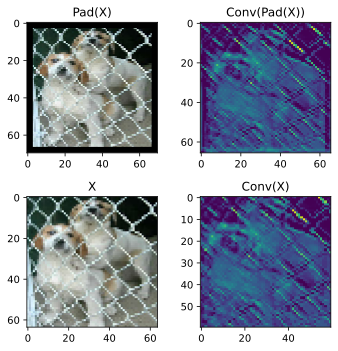

In [8]:
pad = kr.layers.ZeroPadding2D(padding=3)
print(pad(X).shape)

fig, ax = plt.subplots(2, 2, figsize=(5, 5))

ax[0, 0].imshow(pad(X)[0]);
ax[0, 1].imshow(tf_conv(pad(X))[0, :, :, 3]);
ax[1, 0].imshow(X[0]);
ax[1, 1].imshow(tf_conv(X)[0, :, :, 3]);

ax[0, 0].set_title("Pad(X)")
ax[0, 1].set_title("Conv(Pad(X))")
ax[1, 0].set_title("X")
ax[1, 1].set_title("Conv(X)")

fig.tight_layout()

<br>

```{figure} ../../img/imagenet.png
---
width: 35em
name: imagenet
---
Sample images from the ImageNet dataset {cite}`imagenet`. AlexNet used a kernel of size 11×11 with a stride of 4 over images of size 224×224 in the first layer since objects in the dataset tend to occupy more pixels. 

```

**Output size.** An input feature map with width `w` and equal padding `p`, and kernel size `k` with stride `s` has an output with width `⌊(w + 2p - k)/s + 1⌋`. Note that we have to carefully choose stride and padding values so that the kernel can be placed evenly in the image so that no input pixel is dropped. For $\mathsf{s} = 1,$ kernel size should be odd so that it covers the entire input in a symmetric manner. A common choice is `p = (k - 1)/2` which results in same sized outputs (i.e. **same convolution**). For $\mathsf{s} > 1,$ best practice is to choose a kernel size and the smallest padding such that `s` divides `w + 2p - k` so the entire input image is symmetrically covered by the kernel.

### Max pooling

The **receptive field** of a unit of a hidden layer consists of all units from previous layers that influences its value during forward pass. In particular, units for each class in the softmax layer should have a receptive field that includes the entire input. Otherwise, some parts of the input will not affect the prediction of the model for that class. These regions can be thought of as dead pixels or blind spots of the model for that class. 

```{margin}
Fig 14.2 in {cite}`geron2019hands-on`
```
```{figure} ../../img/receptive_field.png
---
width: 28em
---
Receptive field of a pixel in a convolutional network.
```

Receptive field can be exponentially increased by **downsampling** characterized by aggregating input pixels to make the dimensions of the image smaller for the next layer. This also decreases computation by decreasing the dimension of the feature map and possibly eliminates redundant details.

```{margin}
Figure from: <br>
[`cs231n/conv-nets`](https://cs231n.github.io/convolutional-networks/)
```

```{figure} ../../img/pooling-cs231n.png
---
width: 300px

---

Pooling layer downsamples the volume spatially independently in each channel. The input tensor of size 224 × 224 × 64 is pooled with filter size 2 and stride 2 into output volume of size 112 × 112 × 64.
```

ConvNets use **pooling layers** are nonparametric layers which downsample an input by moving across it like convolutional layers set stride, padding, and kernel size. Pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure. 

In the experiments, we use **max pooling** which takes the maximum value in the region that is covered by its kernel. This makes the network to be invariant to small noise or fine-grained details in the input at the cost of some information loss. It can also be interpreted as a form of competition between neurons since the gradient only flows on the activated neuron.

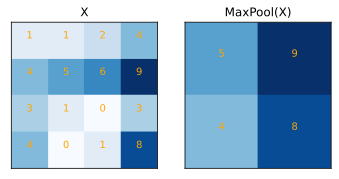

In [9]:
X = tf.convert_to_tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, :, :, None]

pool = kr.layers.MaxPool2D(pool_size=2, strides=2)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
ax[0].set_title("X")
ax[0].imshow(X.numpy()[0, :, :, 0], cmap='Blues', vmin=0)
ax[0].set_xticks([])
ax[0].set_yticks([])
for i in range(4):
    for j in range(4):
        ax[0].text(j, i, X[0, i, j, 0].numpy(), ha="center", va="bottom", color='orange')

ax[1].set_title("MaxPool(X)")
ax[1].imshow(pool(X).numpy().reshape(2, 2), cmap='Blues', vmin=0)
ax[1].set_xticks([])
ax[1].set_yticks([])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, pool(X)[0, i, j, 0].numpy(), ha="center", va="bottom", color='orange')

fig.tight_layout()

There are two commonly used settings: `k = 2` and `s = 2` where the pooling regions are do not overlap, and the more aggressive overlapping pooling with `k = 3` and `s = 2`. Using larger kernel sizes can be too aggressive resulting in loss of discriminative information. This can be observed in the example below where presence of occlusion is further emphasized by pooling.

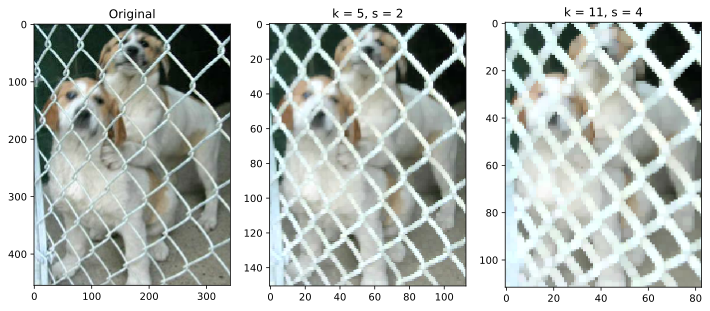

In [10]:
image_raw = tf.io.read_file(str(dog))
image = tf.image.decode_image(image_raw)[None, :, :, :]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image[0, :, :, :])
ax[0].set_title("Original")
ax[1].imshow(kr.layers.MaxPool2D(pool_size=5, strides=3)(image)[0, :, :, :])
ax[1].set_title("k = 5, s = 2")
ax[2].imshow(kr.layers.MaxPool2D(pool_size=11, strides=4)(image)[0, :, :, :])
ax[2].set_title("k = 11, s = 4");

## Implementing a ConvNet

ConvNets consists of stacking `[Conv→ReLU→Pool]` blocks. This is typical in the design of network architectures: using **blocks** composed of layers that together forms a basic functional unit. Here the spatial dimensions are downsampled while increasing the number of output channels so that network capacity is not diminished. The resulting feature map is small enough to be passed as an input vector to the dense classification subnetwork.

```{margin}
Figure source: <br>
[`github.com/rasbt/`](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_12.png)
```
```{figure} ../../img/convnet.png
---
---
Visualizing the architecture of our CNN network.

```

Note that we use a width of 512 in the last dense layer instead of 1024 indicated in the figure. This significantly reduces the number of parameters of the model. To aid with activation and gradient stability, we add BatchNorm {cite}`batchnorm` layers after each convolution and check whether this improves model performance.

In [11]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)        0

**Remarks.** For convolutional layers, width corresponds to the number of channels of the output feature maps. This can be interpreted as the number of features that the layer learns where each feature is captured by an image. Increasing the width directly increases the capacity of the network, i.e. learning more feature detectors. 

On the other hand, increasing depth results in learning higher level features that are combinations of lower level features in the early layers of the network. This allows using less weights. The tradeoff is that these representations are generally more difficult to optimize towards.

### Training

Training on FashionMNIST {cite}`fashion-mnist` using Adam {cite}`adam`:

In [12]:
from tensorflow.keras.datasets import fashion_mnist

def preprocess(data):
    data = data.reshape((-1, 28, 28, 1))
    data = data.astype('float32') / 255.
    return data 

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = preprocess(X_train)
X_test  = preprocess(X_test)

# Split train and validation sets
X_valid = X_train[:10000]
y_valid = y_train[:10000]
X_train = X_train[10000:]
y_train = y_train[10000:]


# Compile model with Adam and cross-entropy
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model on FashionMNIST data
hist = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32,
    validation_data=(X_valid, y_valid)
)

4431872/4422102 [==============================] - 0s 0us/step


2022-12-05 02:10:44.655278: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.5493 - accuracy: 0.8041 - val_loss: 0.3396 - val_accuracy: 0.8726
Epoch 2/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3645 - accuracy: 0.8674 - val_loss: 0.2605 - val_accuracy: 0.9038
Epoch 3/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3094 - accuracy: 0.8871 - val_loss: 0.2579 - val_accuracy: 0.9058
Epoch 4/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2731 - accuracy: 0.9005 - val_loss: 0.2411 - val_accuracy: 0.9124
Epoch 5/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2480 - accuracy: 0.9093 - val_loss: 0.2202 - val_accuracy: 0.9202
Epoch 6/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2216 - accuracy: 0.9193 - val_loss: 0.2496 - val_accuracy: 0.9033
Epoch 7/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2052 - accuracy: 0.9245 - val_loss: 0.2252 - val_accuracy:

Kernels learned by the model in the first layer:

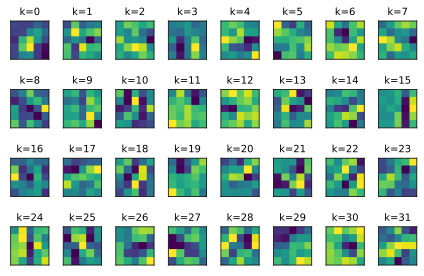

In [13]:
fig, ax = plt.subplots(4, 8)
for i in range(32):
    ax[divmod(i, 8)].set_title(f"k={i}", fontsize=10)
    ax[divmod(i, 8)].imshow(model.layers[0].weights[0][:, :, 0, i].numpy());
    ax[divmod(i, 8)].set_xticks([])
    ax[divmod(i, 8)].set_yticks([])
    
fig.tight_layout()

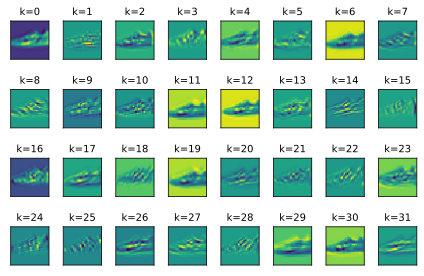

In [14]:
fig, ax = plt.subplots(4, 8)
for i in range(32):
    ax[divmod(i, 8)].set_title(f"k={i}", fontsize=10)
    ax[divmod(i, 8)].imshow(model.layers[0](X_train[1][None, :, :, :])[0, :, :, i]);
    ax[divmod(i, 8)].set_xticks([])
    ax[divmod(i, 8)].set_yticks([])
    
fig.tight_layout() 

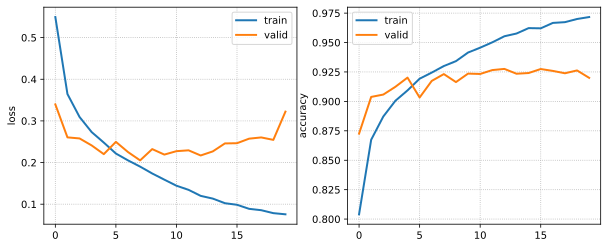

In [15]:
def plot_model_history(history, ax, metric='accuracy', label='', **kwargs):
    """Plotting result of Keras model training."""

    train_label = f'train ({label})' if len(label) > 0 else 'train'
    valid_label = f'valid ({label})' if len(label) > 0 else 'valid'
    ax[0].plot(history.history['loss'], label=train_label, color="C0", **kwargs)
    ax[0].plot(history.history['val_loss'], label=valid_label, color="C1", **kwargs)
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[0].grid(linestyle='dotted')

    ax[1].plot(history.history[metric], label=train_label, color="C0", **kwargs)
    ax[1].plot(history.history[f'val_{metric}'], label=valid_label, color="C1", **kwargs)
    ax[1].set_ylabel(metric)
    ax[1].legend()
    ax[1].grid(linestyle='dotted')


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, linewidth=2)

In [16]:
print(f"Test accuracy: {model.evaluate(X_test, y_test)[1]}")

313/313 [==============================] - 1s 3ms/step - loss: 0.3807 - accuracy: 0.9160
Test accuracy: 0.9160000085830688


In [17]:
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

pred_proba = model.predict(X_test)
pred = np.argmax(pred_proba, axis=1)
pred_table = pd.DataFrame({
    'pred': pred, 
    'proba': [pred_proba[i, j] for (i, j) in enumerate(pred)], 
    'true': y_test.reshape(-1),
})

Plotting the examples where model is least confident in its prediction:

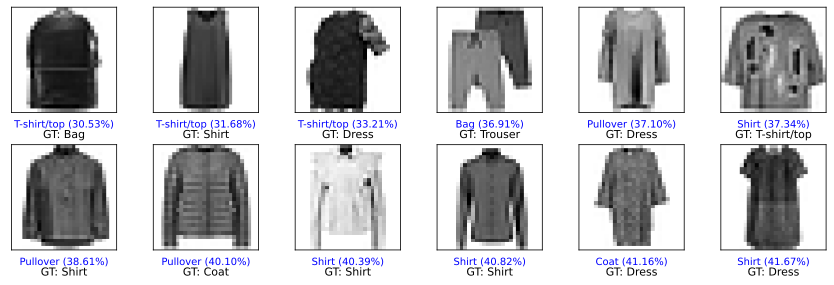

In [18]:
fig = plt.figure(figsize=(12, 4))
worst_preds = pred_table.sort_values('proba')[:12]

for i in range(12):
    img_index = worst_preds.index[i]
    image = X_test[img_index]
    row = worst_preds.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"{class_names[row['pred']]} ({row['proba']*100:.2f}%)", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

### Effect of BatchNorm

Since we already have our experiment set up, might as well run some tests. Recall that we fitted batch normalization layers after the convolutional layers. Let us see how this affects model training.

In [19]:
model_no_bn = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])


# Build and compile with Adam and cross-entropy
model_no_bn.build(input_shape=(None, 28, 28, 1))
model_no_bn.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train on FashionMNIST data
hist_no_bn = model_no_bn.fit(
    X_train, y_train, 
    epochs=20,
    batch_size=32,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
1563/1563 [==============================] - 6s 3ms/step - loss: 0.4447 - accuracy: 0.8408 - val_loss: 0.3125 - val_accuracy: 0.8883
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2900 - accuracy: 0.8936 - val_loss: 0.2404 - val_accuracy: 0.9101
Epoch 3/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2509 - accuracy: 0.9073 - val_loss: 0.2325 - val_accuracy: 0.9138
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2220 - accuracy: 0.9189 - val_loss: 0.2305 - val_accuracy: 0.9176
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1979 - accuracy: 0.9257 - val_loss: 0.2176 - val_accuracy: 0.9210
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1767 - accuracy: 0.9335 - val_loss: 0.2155 - val_accuracy: 0.9228
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1585 - accuracy: 0.9399 - val_loss: 0.2496 - val_accuracy:

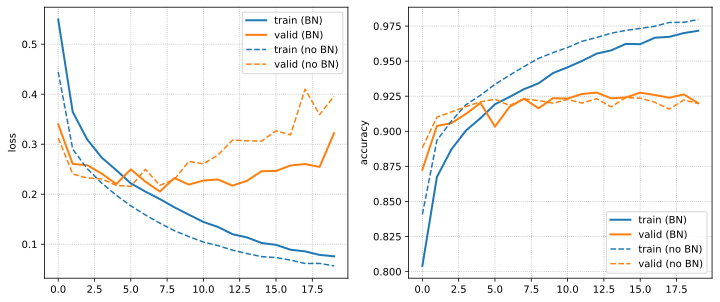

In [20]:
# Plot on same axis as prev model
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_model_history(history=hist, ax=ax, label="BN", linewidth=2)
plot_model_history(history=hist_no_bn, ax=ax, label="no BN", linestyle="dashed")

Model with batch normalization exhibits less overfitting.

In [21]:
print(f"Test accuracy (BN):     {model.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy (w/o BN): {model_no_bn.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")

Test accuracy (BN):     91.60%
Test accuracy (w/o BN): 91.72%


## Data augmentation

In this section, we will create a convolutional network for classifying whether an image of a person is smiling or not. We use [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) {cite}`celeb_a` which contains 202,599 images of faces of celebrities. To speed up training we will only use a small subset consisting of 16,000 faces. However, this is a small dataset for image classification. To train a network that generalizes, we have to use **data augmentation**. This technique incorporates transformed versions of the original images into the dataset. 

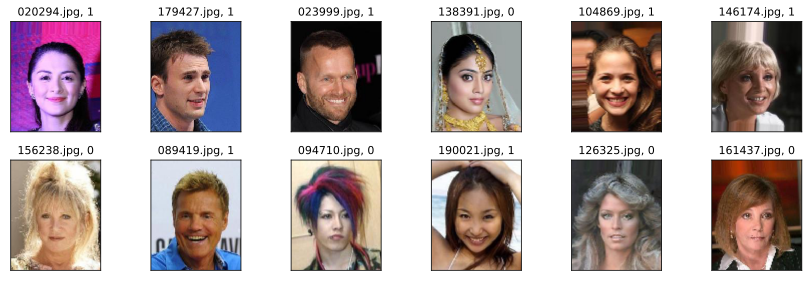

In [22]:
image_dir_path = DATASET_DIR / "celeba-dataset" / "img_align_celeba" / "img_align_celeba"
face_file_list = sorted([str(path) for path in image_dir_path.glob("*.jpg")])
random.shuffle(face_file_list)

# Get id -> target dictionary
dataset_path = DATASET_DIR / 'celeba-dataset'
attr = pd.read_csv(dataset_path / 'list_attr_celeba.csv')[['image_id', 'Smiling']]
attr['Smiling'] = attr['Smiling'].map({1: 1, -1: 0})
get_smile = dict(zip(attr.image_id, attr.Smiling))

# Plot examples from dataset
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_path = face_file_list[i]
    image_id = image_path.split('/')[-1]
    label = get_smile[image_id]
    image = plt.imread(image_path)

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.imshow(image)
    ax.set_title(f"{image_id}, {label}", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

### Transforms

We augment the training dataset with randomly cropped and randomly flipped versions of the original images. This has the effect of perturbing the position of a smile by a small amount. It is also clear that flipping makes sense since the face has mirror symmetry. In general, the transformed input should stay within the input distribution and have the same ground truth label as the original input.

In [23]:
# Full data augmentation pipeline
transform = kr.Sequential([
    kr.layers.RandomCrop(178, 178),
    kr.layers.RandomFlip("horizontal"),
    kr.layers.Resizing(96, 96),
    kr.layers.Rescaling(1./255)
])

def load_jpeg(file_path):
    image_raw = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    return image

def image_id(file_path):
    return file_path.split('/')[-1] 

def create_image_dataset(file_list):
    labels = [get_smile[image_id(file_path)] for file_path in file_list]
    paths_ds = tf.data.Dataset.from_tensor_slices((file_list, labels))
    image_ds = paths_ds.map(lambda file_path, label: (load_jpeg(file_path), label))
    return image_ds

### Augmented datasets

Observe that the mapping is applied lazily each time the dataset is iterated over. The ordering between `shuffle` and `map` is important since `shuffle` maintains state across iterations and we get different augmentations for each epoch during training. As usual with Keras layers stochasticity can be turned off by setting `training=False` at inference.

In [24]:
def create_dataloader(file_list, *, batch_size, train):
    """Create TF dataset for training and validation."""

    ds = create_image_dataset(file_list)
    if train:
        ds = ds.shuffle(3000)

    # order important! shuffle -> batch -> map
    ds = ds.batch(batch_size, drop_remainder=train)
    ds = ds.map(lambda x, y: (transform(x, training=train), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

The following tracks three sample images across multiple epochs:

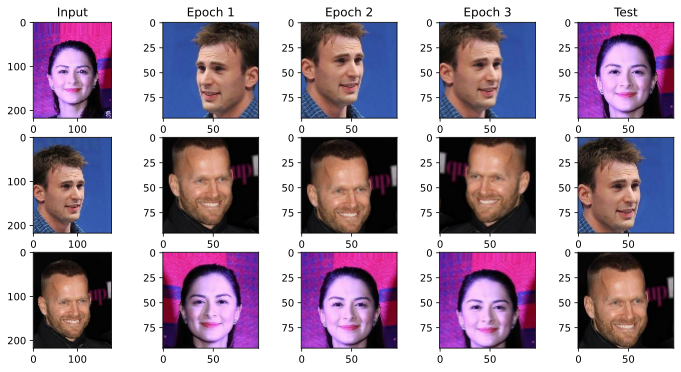

In [25]:
fig, ax = plt.subplots(3, 5, figsize=(12, 6))

# Input data
ax[0, 0].set_title(f"Input")
sample = create_image_dataset(face_file_list[:3])
for b, (x, y) in enumerate(sample):
    ax[b, 0].imshow(x.numpy())

# Training
train_demo = create_dataloader(face_file_list[:3], batch_size=1, train=True)
for epoch in range(1, 4):
    ax[0, epoch].set_title(f"Epoch {epoch}")
    for b, batch in enumerate(train_demo):
        x, y = batch
        ax[b, epoch].imshow(x[0].numpy())

# Inference: use same images for comparison
test_demo = create_dataloader(face_file_list[:3], batch_size=1, train=False)
ax[0, 4].set_title(f"Test")
for b, batch in enumerate(test_demo):
    x, y = batch
    ax[b, 4].imshow(x[0].numpy())

Creating the data loaders and checking if labels are balanced:

In [26]:
from tqdm.auto import tqdm

train = face_file_list[:16000]
valid = face_file_list[16000:17000]
test  = face_file_list[17000:18000]

ds_train = create_dataloader(train, batch_size=32, train=True)
ds_valid = create_dataloader(valid, batch_size=32, train=False)
ds_test  = create_dataloader(test,  batch_size=32, train=False)

print(r"Fraction smile:")
name = ['train', 'valid', 'test']
for i, ds in enumerate([ds_train, ds_valid, ds_test]):
    Y = tf.concat([tf.cast(y, tf.float32) for _, y in tqdm(ds)], axis=0)
    print(f"  {name[i]:5s}   {tf.reduce_mean(Y)*100:.1f}%")

Fraction smile:
  train   48.2%
  valid   49.8%
  test    47.6%


### Model = Conv + GAP

Now that we have our data loaders, let us look at the model architecture that we will use for smile classification. The input data goes through four convolutional layers to make 32, 64, 128, and 256 feature maps using `3×3` same convolutions, `2×2` nonoverlapping max-pooling blocks. Batch normalization layers are also included for regularization.

In [27]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding="same"),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    kr.layers.Dropout(0.3),

    kr.layers.Conv2D(filters=64, kernel_size=3, padding="same"),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    kr.layers.Dropout(0.3),
    
    kr.layers.Conv2D(filters=128, kernel_size=3, padding="same"),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=256, kernel_size=3, padding="same"),
    kr.layers.ReLU(),
    kr.layers.GlobalAveragePooling2D(),
    
    kr.layers.Flatten(),
    kr.layers.Dense(units=2, activation="softmax")
])

model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)       

At the final convolutional layer, we have 256 many 8 × 8 feature maps. Flattening this into a 256 × 8 × 8 = 16,384 long vector results in the loss of learned semantic structure. Not to mention the excess in capacity of the dense layer that takes this vector as input.

An alternative that we use here is a **global average-pooling** (GAP) layer which averages all pixels in the 8 × 8 feature map into a single pixel. Averaging over the spatial dimensions can make the model more robust to small spatial translations in the input. But more importantly, compressing the spatial dimension allows us to preserve the channel structure, while reducing the output to a vector of length 256. This vector can then be passed to a dense layer to perform classification.

### Training and results

Training the model with Adam with a learning rate of $10^{-3}$ and a batch size of 32.

In [28]:
model.compile(
    loss=kr.losses.SparseCategoricalCrossentropy(),
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

callback = kr.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5,
    restore_best_weights=True,
)

# Fit model with data augmentation
hist = model.fit(
    ds_train,
    epochs=50,
    validation_data=ds_valid,
    callbacks=[callback],
)

Epoch 1/50
500/500 [==============================] - 22s 38ms/step - loss: 0.6921 - accuracy: 0.5182 - val_loss: 0.6909 - val_accuracy: 0.5020
Epoch 2/50
500/500 [==============================] - 21s 38ms/step - loss: 0.6900 - accuracy: 0.5193 - val_loss: 0.6906 - val_accuracy: 0.5270
Epoch 3/50
500/500 [==============================] - 21s 37ms/step - loss: 0.6839 - accuracy: 0.5464 - val_loss: 0.6891 - val_accuracy: 0.5360
Epoch 4/50
500/500 [==============================] - 21s 37ms/step - loss: 0.6830 - accuracy: 0.5517 - val_loss: 0.6871 - val_accuracy: 0.5510
Epoch 5/50
500/500 [==============================] - 20s 36ms/step - loss: 0.6797 - accuracy: 0.5606 - val_loss: 0.6782 - val_accuracy: 0.5690
Epoch 6/50
500/500 [==============================] - 19s 35ms/step - loss: 0.6746 - accuracy: 0.5769 - val_loss: 0.6725 - val_accuracy: 0.5890
Epoch 7/50
500/500 [==============================] - 20s 37ms/step - loss: 0.6669 - accuracy: 0.5949 - val_loss: 0.6678 - val_accuracy:

Pushing these gradients to the input node. Note that [dimensions](https://en.wikipedia.org/wiki/Dimensional_analysis) nicely check out:

The learned kernels look impressive:

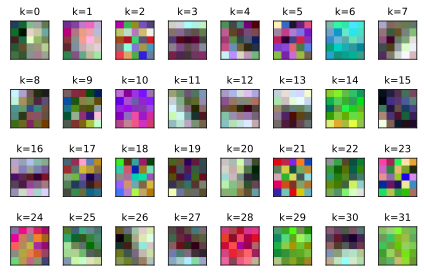

In [29]:
fig, ax = plt.subplots(4, 8)
for i in range(32):
    K = model.layers[0].weights[0][:, :, :, i].numpy()
    K = (K - K.min()) / (K.max() - K.min())
    ax[divmod(i, 8)].set_title(f"k={i}", fontsize=10)
    ax[divmod(i, 8)].imshow(K);
    ax[divmod(i, 8)].set_xticks([])
    ax[divmod(i, 8)].set_yticks([])
    
fig.tight_layout()

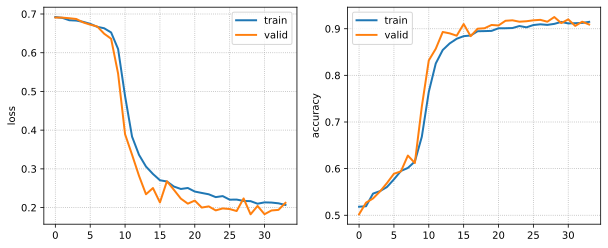

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, linewidth=2)

**Remark.** Turning off data augmentation results in extreme divergence where the model overfits early on in the training. Adding random transformations on the train set makes it harder for the model to memorize aspects of smile that only exist in how the training data is presented, e.g. looking at smiles in the lower center of images. At the same time, the model learns to pick up representations that are invariant to these random perturbations in the inputs.

In [31]:
print(f"train acc: {model.evaluate(ds_train, verbose=0)[1] * 100:.2f}%") # stochastic
print(f"valid acc: {model.evaluate(ds_valid, verbose=0)[1] * 100:.2f}%")
print(f"test  acc: {model.evaluate(ds_test,  verbose=0)[1] * 100:.2f}%")

train acc: 92.61%
valid acc: 92.50%
test  acc: 93.40%


In [32]:
X = []
Y = []
for x, y in ds_test:
    X.append(x)
    Y.append(y)

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

pred_proba = model.predict(X)[:, 1]
pred_table = pd.DataFrame({'pred': pred_proba, 'truth': Y})
pred_table['confidence'] = np.abs(pred_table['pred'] - 0.5) / 0.5
pred_table['correct'] = (pred_table['pred'] > 0.5) == pred_table['truth']
pred_table.head(5)

,pred,truth,confidence,correct
0,0.997114,1,0.994228,True
1,0.186678,0,0.626645,True
2,0.995416,1,0.990832,True
3,0.926031,1,0.852063,True
4,0.148706,0,0.702588,True


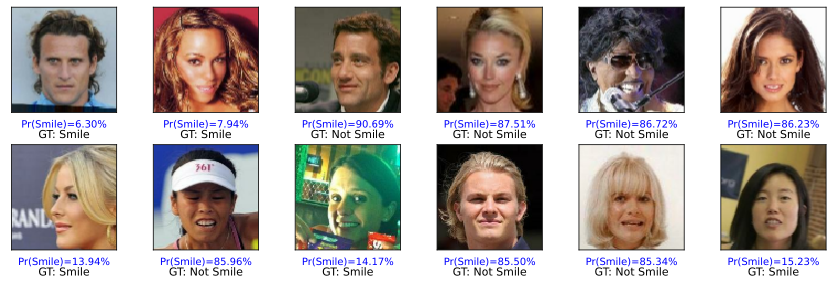

In [33]:
class_names = {
    0: 'Not Smile',
    1: 'Smile'
}

confused = (pred_table
    .sort_values('confidence', ascending=False)
    .query('correct == False')
)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    img_index = confused.index[i]
    image = X[img_index]
    row = confused.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['truth']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where model is confidently wrong. Here we have to look out for incorrect labels. Otherwise, these are examples where the model has the highest loss. This may be fixed by preprocessing or perhaps adding further augmentation (e.g. adjust brightness). Images with ambiguous labels should have low prediction confidence. See next figure.

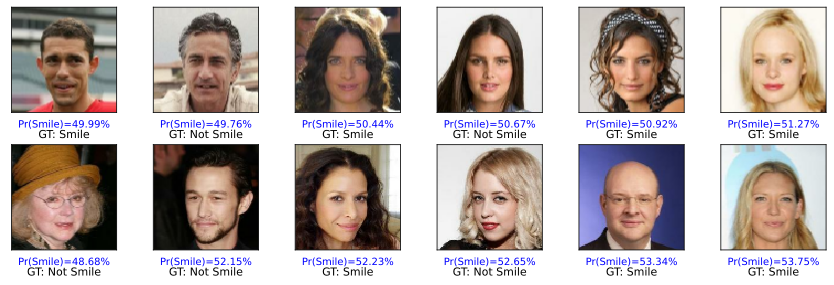

In [34]:
unsure = pred_table.sort_values('confidence', ascending=True)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_index = unsure.index[i]
    image = X[image_index]
    row = unsure.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['truth']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where model have low confidence. Indeed, for some of these faces have ambiguous smiles. But otherwise, we can see that the model is having trouble with smiles that do not show teeth.

## Class activation maps

Observe that class scores in a GAP-CNN network are obtained by a linear combination of the average pixel values in each activation map. Since spatial ordering is preserved by convolutional layers, activations should indicate which pixels in the input that is in its receptive field triggered the activation, i.e. whose local representation matched the pattern in the kernel. When using a GAP layer, all activations in a feature map are blended into a single number. A weight is learned for this number for each class when training the softmax.

Notice that the weight can be applied to each pixel in the activation map resulting in what looks like a heatmap for that particular class. This is precisely a construction of **class activation maps** (CAMs) {cite}`cams` for models with GAP layers. This works particularly well with ReLU activation so that the activation maps contain activation regions consisting of pixels with positive values. Hence, a GAP-CNN network does not only tell us what objects are present in the image, it can also tell us where these objects are in the image with no further training!

<br>

```{figure} ../../img/cams.png
---
width: 50em
---
{cite}`cams` GAP layer flattens the final feature map by collapsing its spatial dimensions. The activation maps indicate that $\mathsf{w}_1 \approx 0$ for the Australian terrier class.
```

Looking at the above model summary, we see that the GAP layer output has 258 units. To construct the class activation maps, for each input $\boldsymbol{\mathsf x}$ we take the activations of the final feature extraction layer which has shape (8, 8, 256) as **activation maps** $f_i(\boldsymbol{\mathsf x})$ of shape (8, 8) for $i = 1, \ldots, 256$ with nonnegative pixel values. Then we take the weights of the dense layer ${\mathsf w}_{ij}$ which maps the $i$th output of the GAP layer to $j$th class and compute the sum

$$\textsf{CAM}(\boldsymbol{\mathsf x}, j) = \sum_{i=1}^{256} f_i(\boldsymbol{\mathsf x})\,{\mathsf w}_{ij}.$$

The resulting image is 8×8 which we can resize for better resolution. Then, we overlay this on the input image $\boldsymbol{\mathsf x}$ resized to the same height and width. Thus, we have expanded the linear combination of zero-dimensional average activation values to a linear combination of 2-dimensional activation maps. The following code block construct CAMs for test examples.

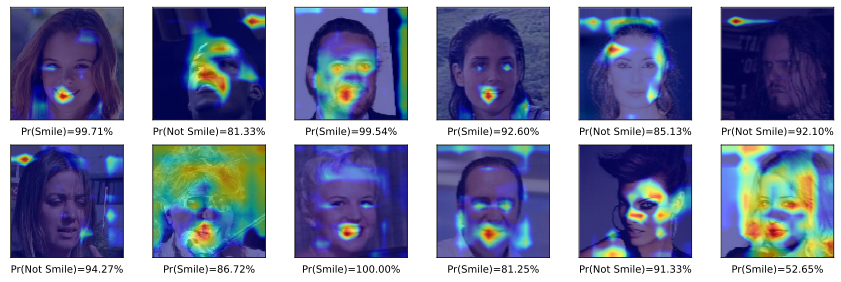

In [35]:
from functools import reduce

def calculate_cam(x, t: int, height: int, width: int):
    """CAM of one instance taken with respect to the predicted label.
    Note that this function has no access to the ground truth label."""
    
    class_weight = model.layers[-1].get_weights()[0] # (256, m) where m = 2 (# classes)
    resize = kr.layers.Resizing(height, width)

    # Apply layers up to final conv. activation. 
    act_map = reduce(lambda x, f: f(x), model.layers[:-4], x)
    weights = class_weight[:, [t]]
    cam = act_map @ weights         # (1, h, w, 256) @ (256, 1)
    cam = resize(cam).numpy()[0]    # remove batch dim => (height, width, 1)
    return cam


def plot_cam(X, height=96, width=96, threshold=0.0):
    """Plot class activation maps (CAM) for each image in batch.
    The CAM will be taken with respect to the predicted label."""

    class_label = {0: 'Not Smile', 1: 'Smile'}
    resize = kr.layers.Resizing(height, width)

    fig, ax = plt.subplots(2, 6, figsize=(12, 4))
    for b in range(12):
        x = X[b, :, :, :][None, :, :, :]
        t = tf.argmax(model(x), axis=1).numpy()[0]
        
        cam = calculate_cam(x, t, height, width)
        u = cam.min()
        v = cam.max()
        cam = (cam - u) / (v - u)
        cam = np.clip(cam, threshold, 1.0)
        
        ax[divmod(b, 6)].imshow(resize(x)[0])
        ax[divmod(b, 6)].imshow(cam, alpha=0.75, cmap='jet', interpolation='sinc')
        ax[divmod(b, 6)].set_xlabel(f"Pr({class_label[t]})={model(x)[0, t]*100:.2f}%", color='black')
        ax[divmod(b, 6)].set_xticks([])
        ax[divmod(b, 6)].set_yticks([])

    fig.tight_layout()


plot_cam(X[:12], threshold=0.50) # Detect smile

**Figure.** CAMs of test images for the predicted class. Observe that the model naturally focuses on the face and eyes to predict the positive class. On the other hand, the model activates outside of these regions when predicting the negative class. Earlier attempts of using 3 × 3 convolutions in the first layer and smaller sized inputs generally resulted in worse looking CAMs across different random seeds. 

<br>

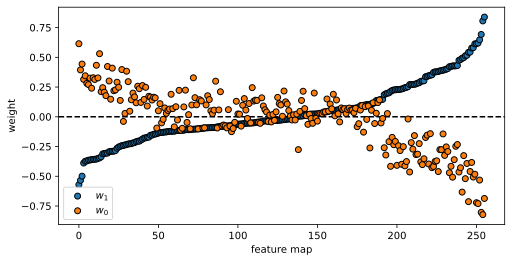

In [36]:
W = model.layers[-1].weights[0].numpy()

w0 = W[:, 0]
w1 = W[:, 1]
q = np.argsort(w1)

plt.figure(figsize=(8, 4))
plt.axhline(0, color='black', linestyle='dashed', zorder=-3)
plt.scatter(range(256), w1[q], edgecolor='black', label="$w_1$")
plt.scatter(range(256), w0[q], edgecolor='black', label="$w_0$")
plt.ylabel("weight")
plt.xlabel("feature map")
plt.legend();

**Figure.** Dense layer weights corresponding to each feature map. Notice that the weights for the negative and positive classes generally have opposite signs. This indicates that kernels in the last convolutional layer detect regions that are predictive of either class. This was observed above for test images.

## Transfer learning

**Transfer learning** consists of taking weights, and hence feature representations, learned on one problem, and leveraging them on a new, similar problem. In the following experiment, we will use a [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) {cite}`mobilenet` model pretrained on ImageNet. This has around 2.3 million parameters and was designed to have fast inference times for resource constrained environments. This section follows the Keras guide [*Transfer learning & fine-tuning*](https://keras.io/guides/transfer_learning/). 


```{margin}
**Figure 8.12** in {cite}`keras2`
``` 
```{figure} ../../img/transfer-learning.png
---
width: 40em
---
Replacing with a new classifiers while keeping the same convolutional base.
```

Observe that the convolutional networks we encountered consist of two subnetworks: a convolutional base, that acts as a feature extractor, and a classifier on top of the base network that processes the extracted features to get class probabilities. The idea behind transfer learning is that we can take the convolutional base, that is extensively trained on a large dataset, and use its learned representations to train a new classifier on a similar task. This leads us to the following workflow:

 1. Instantiate a base model and load pre-trained weights into it.
 2. Freeze all layers in the base model by setting its `trainable` attribute to `False`.
 4. Add new layers on top of the base model.
 5. Train your new model on your new dataset.

An alternative workflow is to pass the input data *once* to the base model to get feature vectors. These vectors are then used to train a new, smaller model. This is cheaper, but we cannot use it along with data augmentation which transforms input data at each training iteration.

In [37]:
base_model = kr.applications.MobileNetV2(
    weights='imagenet',         # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),    # We will have to resize for our 64x64x3 train dataset.
    include_top=False           # Do not include the ImageNet classifier at the top.
)

# Freeze the weights
base_model.trainable = False

# Stack a classification subnetwork on top of base model
inputs = kr.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)          # Inference mode! ⚠⚠⚠
x = kr.layers.GlobalAveragePooling2D()(x)       # 3x3x1280 -> 1x1x1280. Remove for performance. 
x = kr.layers.Flatten()(x)
x = kr.layers.Dense(256, activation='relu')(x)
x = kr.layers.Dropout(0.5)(x)
outputs = kr.layers.Dense(1)(x)

model = kr.Model(inputs, outputs)
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
________________________________________________________________

**Remark.** Instantiating the base model in inference mode is important as discussed in the following section.

In [38]:
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Fit model with data augmentation
hist_transfer = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_valid
)

Epoch 1/20
500/500 [==============================] - 24s 39ms/step - loss: 0.5809 - binary_accuracy: 0.6957 - val_loss: 0.5184 - val_binary_accuracy: 0.7200
Epoch 2/20
500/500 [==============================] - 21s 39ms/step - loss: 0.5233 - binary_accuracy: 0.7297 - val_loss: 0.5058 - val_binary_accuracy: 0.7510
Epoch 3/20
500/500 [==============================] - 20s 38ms/step - loss: 0.5068 - binary_accuracy: 0.7374 - val_loss: 0.4912 - val_binary_accuracy: 0.7480
Epoch 4/20
500/500 [==============================] - 21s 40ms/step - loss: 0.4971 - binary_accuracy: 0.7426 - val_loss: 0.4893 - val_binary_accuracy: 0.7520
Epoch 5/20
500/500 [==============================] - 21s 38ms/step - loss: 0.4872 - binary_accuracy: 0.7516 - val_loss: 0.4839 - val_binary_accuracy: 0.7460
Epoch 6/20
500/500 [==============================] - 22s 42ms/step - loss: 0.4853 - binary_accuracy: 0.7499 - val_loss: 0.4893 - val_binary_accuracy: 0.7500
Epoch 7/20
500/500 [==============================] 

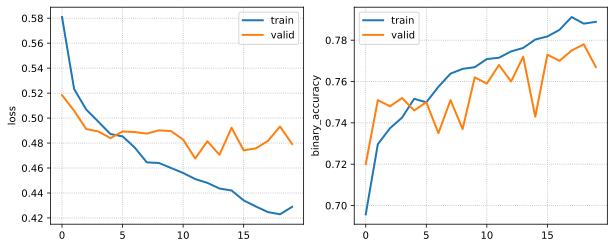

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist_transfer, ax=ax, metric='binary_accuracy', linewidth=2)

In [40]:
print(f"Train accuracy: {model.evaluate(ds_train, verbose=0)[1] * 100:.2f}%")
print(f"Valid accuracy: {model.evaluate(ds_valid, verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate(ds_test,  verbose=0)[1] * 100:.2f}%")

Train accuracy: 81.52%
Valid accuracy: 76.70%
Test accuracy:  77.50%


### Fine-tuning

A last optional step is **fine-tuning** which consists of unfreezing the pre-trained model, or part of it, on the new task with very low learning rate. This can potentially achieve meaningful improvements. But could also potentially lead to quick overfitting due to the potentially large number of parameters in the base model which is why we use a small learning rate. 

Note that it is critical to fine-tune a model only after the model with frozen layers has been trained to convergence. Mixing pretrained layers with randomly initialized layers will destroy the pretrained weights due to large gradient updates during the early stages of training.

In [41]:
# Unfreeze the base model.
base_model.trainable = True

# Recompile to take unfreezing into account.
model.compile(
    optimizer=kr.optimizers.Adam(1e-5),  # Very low learning rate
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Stop before it overfits!
callback = kr.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

# Batch normalization still runs in inference mode. (See appendix.)
epochs = 10
hist_finetune = model.fit(
    ds_train,
    epochs=epochs, 
    validation_data=ds_valid,
    callbacks=[callback]
)

Epoch 1/10
500/500 [==============================] - 36s 62ms/step - loss: 0.3840 - binary_accuracy: 0.8120 - val_loss: 0.3934 - val_binary_accuracy: 0.8090
Epoch 2/10
500/500 [==============================] - 32s 61ms/step - loss: 0.3120 - binary_accuracy: 0.8520 - val_loss: 0.3763 - val_binary_accuracy: 0.8240
Epoch 3/10
500/500 [==============================] - 32s 61ms/step - loss: 0.2786 - binary_accuracy: 0.8700 - val_loss: 0.3986 - val_binary_accuracy: 0.8110
Epoch 4/10
500/500 [==============================] - 32s 60ms/step - loss: 0.2572 - binary_accuracy: 0.8813 - val_loss: 0.2930 - val_binary_accuracy: 0.8690
Epoch 5/10
500/500 [==============================] - 32s 61ms/step - loss: 0.2351 - binary_accuracy: 0.8941 - val_loss: 0.2876 - val_binary_accuracy: 0.8660
Epoch 6/10
500/500 [==============================] - 31s 59ms/step - loss: 0.2231 - binary_accuracy: 0.8973 - val_loss: 0.2929 - val_binary_accuracy: 0.8620
Epoch 7/10
500/500 [==============================] 

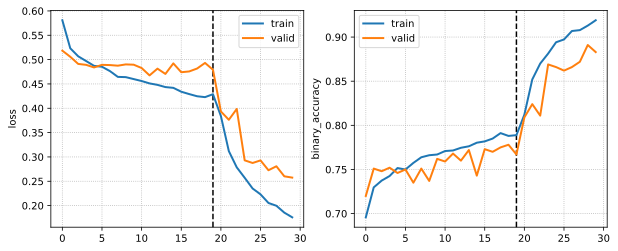

In [42]:
for key in hist_transfer.history.keys():
    hist_finetune.history[key] = hist_transfer.history[key] + hist_finetune.history[key]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].axvline(len(hist_transfer.history["loss"]) - 1, color="black", linestyle="dashed")
ax[1].axvline(len(hist_transfer.history["loss"]) - 1, color="black", linestyle="dashed")
plot_model_history(history=hist_finetune, ax=ax, metric="binary_accuracy", linewidth=2)

Fine-tuning drastically improves model performance, but as expected the model quickly overfits after a few epochs due to overcapacity. Although we were not able to obtain a better scores below with fine-tuning compared to our previous smile classification convnet, we expect better results using more powerful hardware.

In [43]:
print(f"train acc: {model.evaluate(ds_train, verbose=0)[1] * 100:.2f}%")
print(f"valid acc: {model.evaluate(ds_valid, verbose=0)[1] * 100:.2f}%")
print(f"test  acc: {model.evaluate(ds_test,  verbose=0)[1] * 100:.2f}%")

train acc: 93.60%
valid acc: 88.30%
test  acc: 89.60%


### Appendix: BatchNorm

Freezing weights (`trainable=False`) make BatchNorm layers run in inference mode (`training=False`). This is not overridden by running the wrapping model in training mode. This means that BatchNorm statistics will not update during transfer learning. Note that while `trainable` and `training` are orthogonal concepts in principle, this default behavior makes sense since the trainable parameters in the BatchNorm layers of the base model are fixed during transfer learning.

To check this behavior, we define a function that prints the sum of BatchNorm statistics before and after a call in training mode:

In [44]:
def simulate_train(model, bn_index, batch_size=512):
    """Print sum of BN weights before and after a train step."""
    
    bn = model.layers[bn_index]
    γ0 = bn.weights[0].numpy()[0]
    μ0 = bn.weights[2].numpy()[0]

    # train step: (1) pass input at train time + (2) update weights 
    with tf.GradientTape() as tape:
        z = model(tf.random.normal([batch_size,]), training=True)

    grads = tape.gradient(z, model.trainable_weights)
    for w, g in zip(model.trainable_variables, grads):
        dw = 10.0 * g
        w.assign_add(-dw)

    γ1 = bn.weights[0].numpy()[0]
    μ1 = bn.weights[2].numpy()[0]

    print(f"(γ):  {γ0} -> {γ1}")
    print(f"(μ):  {μ0} -> {μ1}")

Recall that the standard recipe for transfer learning is to instantiate `base_model` in **inference** mode. Results below also show that this will not be overridden by running the wrapper model in train mode after being initialized in inference mode, so that the layers of the base model will continue to run in inference mode even when we unfreeze the weights during fine-tuning:

In [45]:
# (1a) Freezing weights => BN inference mode.
base_model = kr.layers.BatchNormalization()
base_model.trainable = False

# (1b) Initializing base model in inference mode
x = kr.Input(shape=(1,))
h = base_model(x, training=False)
y = tf.reduce_sum(tf.math.tanh(h) ** 2)
model = kr.Model(x, y)

print("Simulating transfer learning")
simulate_train(model, 1)

# (2) Unfreezing base model weights for fine-tuning
base_model.trainable = True
print("\nSimulating fine-tuning")
simulate_train(model, 1)

Simulating transfer learning
(γ):  1.0 -> 1.0
(μ):  0.0 -> 0.0

Simulating fine-tuning
(γ):  1.0 -> -1853.3482666015625
(μ):  0.0 -> 0.0


This prevents updates on non-trainable weights which are not scaled by the learning rate (set to be really small during fine-tuning) and may suddenly destroy what the model has learned during transfer learning. On the other hand, initializing the model **not** in inference mode results in updates of the moving mean when we unfreeze weights and train for fine-tuning:

In [46]:
# (1a) Freezing weights => BN inference mode.
base_model = kr.layers.BatchNormalization()
base_model.trainable = False

# (1b) Initializing base model NOT in inference mode
x = kr.Input(shape=(1,))
h = base_model(x)                          # <- (!!)
y = tf.reduce_sum(tf.math.tanh(h) ** 2)
model = kr.Model(x, y)

print("Simulating transfer learning")
simulate_train(model, 1)

# (2) Unfreezing base model weights for fine-tuning
base_model.trainable = True
print("\nSimulating fine-tuning")
simulate_train(model, 1)

Simulating transfer learning
(γ):  1.0 -> 1.0
(μ):  0.0 -> 0.0

Simulating fine-tuning
(γ):  1.0 -> -1852.6986083984375
(μ):  0.0 -> 0.0004891009302809834
